#  Trainer MaskDetection

<font size=4> import the necessary packages

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
from tqdm.notebook import tqdm

In [2]:
LR = 1e-4 # means 0.0001 learning rate
EPOCH =20 
BS = 32 # batch size

In [3]:
#imutils help to get images path
imagePaths = list(paths.list_images("dataset")) 
data =[]
labels = []

This way we get the folder name and mark as label

In [4]:
print("🛣full path: "+imagePaths[-1])
print("📁folderName: "+imagePaths[-1].split(os.path.sep)[-2])

🛣full path: dataset\with_mask\prajna.jpg
📁folderName: with_mask


In [5]:
pbar = tqdm(total = len(imagePaths), desc="Progress")
for  imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2] #extract class label
    
    #load and process image after resizing
    image = load_img(imagePath, target_size=(244,244))
    image = img_to_array(image)
    image = preprocess_input(image)
    
    #update/store on list
    data.append(image)
    labels.append(label)
    
    #update progressBar
    pbar.update(1)
pbar.close()

Progress:   0%|          | 0/1376 [00:00<?, ?it/s]

Convert the data and labels to NumPy arrays for traning

In [6]:
print("🔃: Converting to Numpy....")
data = np.array(data, dtype="float32")
labels = np.array(labels)
print("🥂: Conversion completed.")

🔃: Converting to Numpy....
🥂: Conversion completed.


<font  size=4> one-hot encoding on the labels

In [7]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

<font size=3> Train Data 80% and 20% for test

In [8]:
print("🔃:training model..... ")
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=.20, stratify=labels, random_state=42)
print("🎉:training completed.")

🔃:training model..... 
🎉:training completed.


construct the training image generator for data augmentation

In [9]:
#  it will improve generalization
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [10]:
baseModel = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_tensor=Input(shape=(244, 244, 3)))

construct the head of the model that will be placed on top of the base model

In [11]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [12]:
#actual model
model = Model(inputs= baseModel.input, outputs= headModel)

<font size=3.3>Freeze update while first training process

In [13]:
pbar = tqdm(total=len(baseModel.layers), desc="Done")
for layer in baseModel.layers:
    layer.trainable = False
    pbar.update(1)

pbar.close()

Done:   0%|          | 0/154 [00:00<?, ?it/s]

<center><font size=4> Compile Model

In [14]:
opt = Adam(lr =LR, decay= LR/ EPOCH)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

<center><font size=4.2>Train the head of the network

In [15]:
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCH)

Epoch 1/20
34/34 [==============================] - 38s 1s/step - loss: 0.7306 - accuracy: 0.6223 - val_loss: 0.2498 - val_accuracy: 0.9746
Epoch 2/20
34/34 [==============================] - 32s 952ms/step - loss: 0.2854 - accuracy: 0.9490 - val_loss: 0.1183 - val_accuracy: 0.9855
Epoch 3/20
34/34 [==============================] - 32s 949ms/step - loss: 0.1358 - accuracy: 0.9851 - val_loss: 0.0730 - val_accuracy: 0.9928
Epoch 4/20
34/34 [==============================] - 32s 951ms/step - loss: 0.1029 - accuracy: 0.9847 - val_loss: 0.0523 - val_accuracy: 0.9964
Epoch 5/20
34/34 [==============================] - 32s 945ms/step - loss: 0.0688 - accuracy: 0.9898 - val_loss: 0.0413 - val_accuracy: 0.9964
Epoch 6/20
34/34 [==============================] - 32s 946ms/step - loss: 0.0557 - accuracy: 0.9852 - val_loss: 0.0379 - val_accuracy: 0.9891
Epoch 7/20
34/34 [==============================] - 32s 946ms/step - loss: 0.0393 - accuracy: 0.9944 - val_loss: 0.0301 - val_accuracy: 0.9964
Ep

<center><font size=4>Evaluating network & Save model

In [16]:
predIdxs = model.predict(testX, batch_size=BS) # predictions on testing set
predIdxs = np.argmax(predIdxs, axis = 1) #largest predicted probability

print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))
      
model.save("maskDetector11.model", save_format="h5")

              precision    recall  f1-score   support

   with_mask       1.00      0.99      1.00       138
without_mask       0.99      1.00      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



<center><font size=4> Visualize accuracy and loss curves

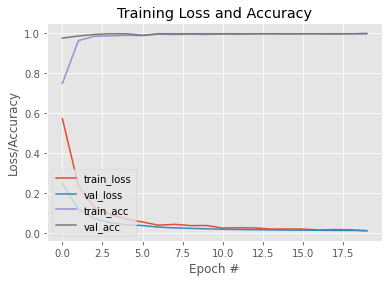

In [17]:
N= EPOCH
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot11")